# Трек 1 - ПГК Оракул / Прогнозирование спроса на грузовые ЖД перевозки


### **Описание решения:**
  1. Загрузка данных.
   - Импорт необходимых библиотек.
   - Предварительное изучение данных.
   - Предварительная подготовка данных.
   - Формирование общего датасета для дальнейшего исследование и предобработки.
  2. Исследовательский анализ:
    - Работа с аномалиями, пропусками и дубликатами.
    - Анализ признаков.
    - Анализ временных рядов.
  3. Анализ данных, формирование признаков:
    - Анализ данных,
    - Удаление неинформативных признаков, генерация ряда признаков, по необходимости.
    - Корреляция признаков.
  4. Построение и обучение модели:
    - Подготовка данных для обучения модели:
      - 1 гипотеза
        - CatBoostRegressor,
        - ARIMA.
      - 2 гипотеза
       - CatBoostRegressor,
      - 3 гипотеза
       - CatBoostRegressor,
  5. Выбор лучшей модели. Тестирование.
  6. Выводы.

## **1. Загрузка данных.**
   - Импорт необходимых библиотек.
   - Загрузка и предварительное изучение данных.
   - Предварительная подготовка данных. Объединение данных.
   - Формирование общего датасета для дальнейшего исследование и предобработки.

In [ ]:
#проект запускаю в colab
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost >> None
    #!pip install orbit-ml >> None
    !pip install pmdarima >> None
    !"{sys.executable}" -m pip install phik >> None

    print('Environment: Google Colab')

# импорт моделей
#import orbit #общий пакет
#from orbit.models import DLT #один из вариантов модели
#from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
#from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
#from orbit.utils.params_tuning import grid_search_orbit #подбор гиперпараметров
from catboost import CatBoostRegressor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import phik
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix

Environment: Google Colab


In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#from phik import phik_matrix

#from joblib import dump
import pickle
import math
import time
import re

# импорт моделей
from sklearn.impute import SimpleImputer
import pmdarima as pm
from pmdarima import auto_arima

# импортируем функции из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm
from scipy import stats

# предварительная обработка
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# кроссвалидация
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit, cross_val_score

# метрики
# метрики
from sklearn.metrics import (
    make_scorer,
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error)


# настройки
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# константа верхний регистр
RANDOM_STATE = 42

In [ ]:
# Относительные ссылки, включая импорты, относительно корневой папки проекта
import os
os.chdir(os.path.dirname(os.getcwd()))

In [ ]:
#если данные храняться на googledisk, подключаем его
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загрузка Excel файла
file_path = '/content/drive/MyDrive/хакатон вагоны/data/Описание данных для хакатона - прогноз ЖД перевозок.xlsx'  # Замените это на реальный путь к вашему файлу
description = pd.read_excel(file_path)
#description = pd.read_csv("/content/drive/MyDrive/хакатон вагоны/data/Описание данных для хакатона - прогноз ЖД перевозок.xlsx")
description

,Часть истории перевозок компаниии ПГК с января 2017 г. до марта 2023 г. включительно,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,Поле,Тип данных,Описание
2,period,date,Месяц предъявления отправки к перевозке в форм...
3,rps,integer,Род Подвижного Состава
4,podrod,integer,Подрод Подвижного Состава
5,filial,integer,"Филиал ""ПГК"""
6,client_sap_id,integer,Код отправителя
7,freight_id,integer,Код груза
8,sender_station_id,integer,Код пункта отправления
9,recipient_station_id,integer,Код пункта назначения


In [ ]:
fact_train_test = pd.read_csv("/content/drive/MyDrive/хакатон вагоны/data/fact_train_test.csv", sep=";", decimal=",", encoding="windows-1251")
client = pd.read_csv( "/content/drive/MyDrive/хакатон вагоны/data/client_mapping.csv", sep=";", decimal=",", encoding="windows-1251")
freight = pd.read_csv("/content/drive/MyDrive/хакатон вагоны/data/freight_mapping.csv", sep=";", decimal=",", encoding="windows-1251")
station = pd.read_csv("/content/drive/MyDrive/хакатон вагоны/data/station_mapping.csv", sep=";", decimal=",", encoding="windows-1251")
forecast_example = pd.read_csv("/content/drive/MyDrive/хакатон вагоны/data/forecast_example.csv", sep=";", decimal=",", encoding="windows-1251")

In [ ]:
# функция первичного знакомства с данными
def express_info(data, name):
    print(f'Информация о {name}:')
    data.info()
    display(data.head(5))
    print()

In [ ]:
express_info(fact_train_test, 'данные для обучения')

Информация о данные для обучения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559232 entries, 0 to 3559231
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   period                  object 
 1   rps                     int64  
 2   podrod                  int64  
 3   filial                  int64  
 4   client_sap_id           int64  
 5   freight_id              int64  
 6   sender_station_id       int64  
 7   recipient_station_id    int64  
 8   sender_organisation_id  int64  
 9   real_weight             float64
 10  real_wagon_count        int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 298.7+ MB


,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1


In [ ]:
express_info(client, 'данные по клиентам')

Информация о данные по клиентам:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418 entries, 0 to 2417
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   client_sap_id  2418 non-null   int64
 1   holding_name   2418 non-null   int64
dtypes: int64(2)
memory usage: 37.9 KB


,client_sap_id,holding_name
0,0,330
1,1,1319
2,2,896
3,3,395
4,4,1629


In [ ]:
express_info(freight, 'данные о коде груза')

Информация о данные о коде груза:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5096 entries, 0 to 5095
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   freight_id          5096 non-null   int64
 1   freight_group_name  5096 non-null   int64
dtypes: int64(2)
memory usage: 79.8 KB


,freight_id,freight_group_name
0,0,0
1,1,14
2,2,5
3,3,5
4,4,5


In [ ]:
express_info(station, 'данные о станциях')

Информация о данные о станциях:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39124 entries, 0 to 39123
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   station_id       39124 non-null  int64
 1   department_name  39124 non-null  int64
 2   railway_name     39124 non-null  int64
dtypes: int64(3)
memory usage: 917.1 KB


,station_id,department_name,railway_name
0,0,0,0
1,1,107,25
2,2,107,25
3,3,164,38
4,4,81,17


In [ ]:
express_info(forecast_example, 'пример выходных данных')

Информация о пример выходных данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239605 entries, 0 to 239604
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   period                  239605 non-null  object 
 1   rps                     239605 non-null  int64  
 2   podrod                  239605 non-null  int64  
 3   filial                  239605 non-null  int64  
 4   client_sap_id           239605 non-null  int64  
 5   freight_id              239605 non-null  int64  
 6   sender_station_id       239605 non-null  int64  
 7   recipient_station_id    239605 non-null  int64  
 8   sender_organisation_id  239605 non-null  int64  
 9   forecast_weight         239605 non-null  float64
 10  forecast_wagon_count    239605 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 20.1+ MB


,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight,forecast_wagon_count
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,73.0,1
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,146.0,2
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,876.0,12
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,473.0,7
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,63.0,1


In [ ]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    # Клиент - холдинг
    df = pd.merge(df, client, how="left", on="client_sap_id")
    # Груз
    df = pd.merge(df, freight, how="left", on="freight_id")
    # Станции
    df = pd.merge(
        df,
        station.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )
    return df

In [ ]:
df = add_master_data_mappings(fact_train_test)

In [ ]:
express_info(df, 'общая таблица')

Информация о общая таблица:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3559232 entries, 0 to 3559231
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   period                     object 
 1   rps                        int64  
 2   podrod                     int64  
 3   filial                     int64  
 4   client_sap_id              int64  
 5   freight_id                 int64  
 6   sender_station_id          int64  
 7   recipient_station_id       int64  
 8   sender_organisation_id     int64  
 9   real_weight                float64
 10  real_wagon_count           int64  
 11  holding_name               float64
 12  freight_group_name         int64  
 13  sender_department_name     int64  
 14  sender_railway_name        int64  
 15  recipient_department_name  int64  
 16  recipient_railway_name     int64  
dtypes: float64(2), int64(14), object(1)
memory usage: 488.8+ MB


,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1,1423.0,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3,1423.0,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1,1423.0,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1,1423.0,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1,1423.0,30,153,12,94,39


In [ ]:
#напишем функцию для исследования данных
def research(data, name, figsize, silent):
    # Выбор только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])

    print(f'Размер данных:      {numeric_data.shape}')
    print(f'Количество явных дубликатов: {numeric_data.duplicated().sum()}')
    print(f'Наличие пропусков:           {numeric_data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')

    logging.getLogger('matplotlib.font_manager').disabled = True
    print(round(numeric_data.isna().mean()*100).sort_values(ascending=False).head(15))

    if not silent:
        print(f'\nПроверка структуры {name}:')
        numeric_data.hist(linewidth=2, histtype='step', figsize=figsize)
        plt.suptitle(f'Гистограмма распределения {name}', y=0.95, fontsize=12)
        plt.show()

    if silent:
        print(f'Корреляция {name}')
        display(numeric_data.corr().round(3)\
                .style\
                .background_gradient(cmap='Pastel2', low= 0, high = 1, axis = 0, subset = None))

    #тепловая карта корреляций
    plt.figure(figsize=(12, 12))
    matrix = np.triu(numeric_data.corr())
    heatmap = sns.heatmap(numeric_data.corr(), annot=True, fmt='.2g',
                      mask=matrix, square=True,
                      cmap='GnBu',  cbar=False,
                      xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)
    plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.90, fontsize=12)
    plt.show()
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    display(numeric_data.describe())

    if not silent:
        display(data.head(5))


Размер данных:      (3559232, 16)
Количество явных дубликатов: 683095
Наличие пропусков:           1277095
Пропущенные данные (в процентном соотношении):
holding_name                 36.0
rps                           0.0
podrod                        0.0
filial                        0.0
client_sap_id                 0.0
freight_id                    0.0
sender_station_id             0.0
recipient_station_id          0.0
sender_organisation_id        0.0
real_weight                   0.0
real_wagon_count              0.0
freight_group_name            0.0
sender_department_name        0.0
sender_railway_name           0.0
recipient_department_name     0.0
dtype: float64

Проверка структуры общая таблица:


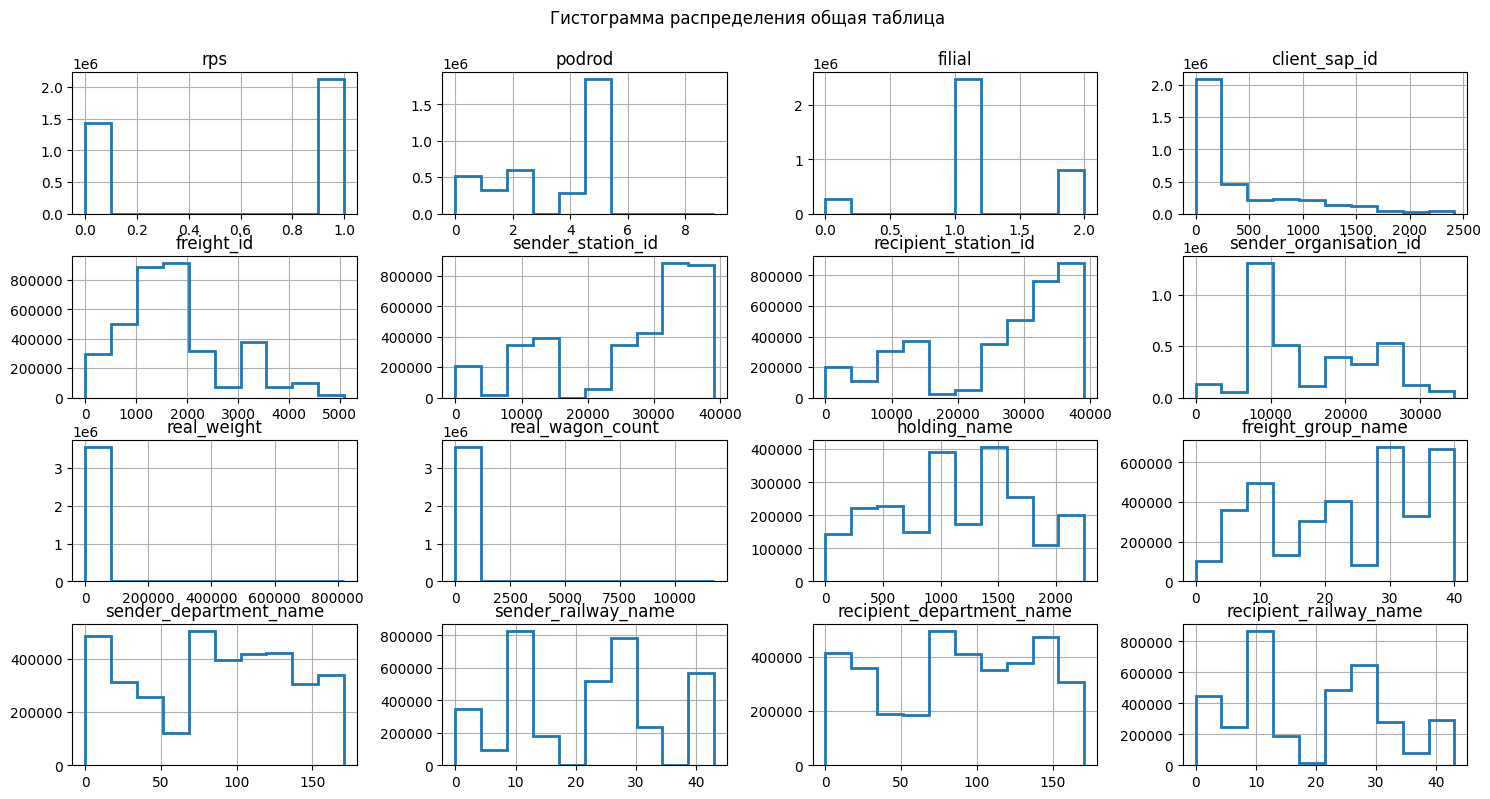

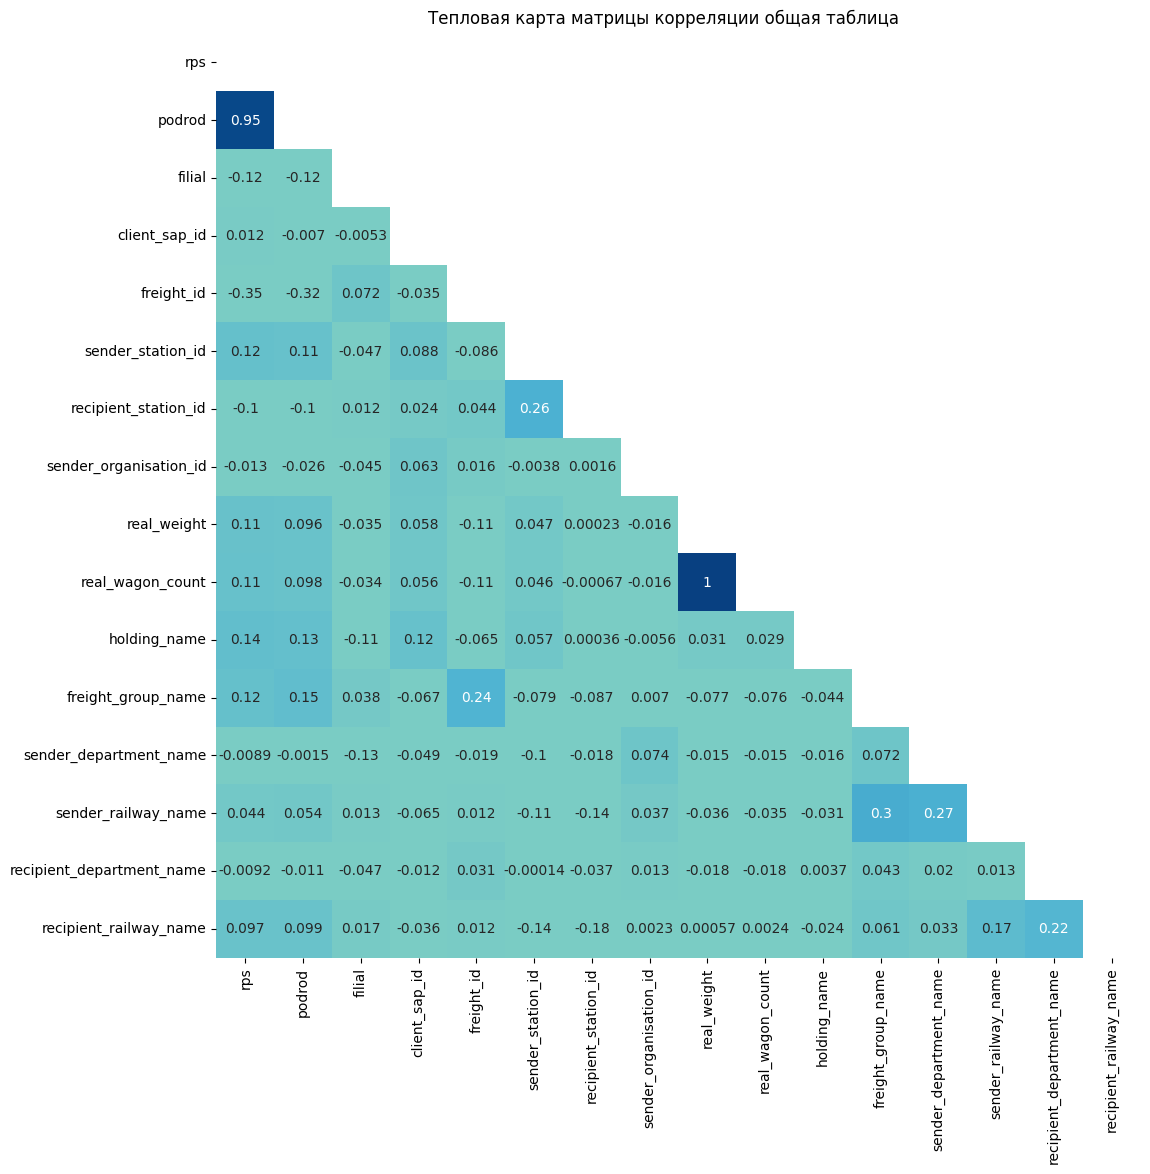

,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
count,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,2282137.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000
mean,0.598,3.338,1.149,386.569,1712.424,26281.220,25981.680,14996.810,1349.654,19.888,1129.518,23.453,86.119,22.271,87.678,19.432
std,0.490,1.965,0.531,539.873,1029.591,11109.796,11461.032,8048.006,9062.866,130.152,574.514,11.954,48.859,12.381,49.134,11.901
min,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.000,-6.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,2.000,1.000,-1.000,1059.000,14272.000,13731.000,7856.000,65.000,1.000,602.000,11.000,43.000,10.000,43.000,10.000
50%,1.000,5.000,1.000,108.000,1622.000,30519.000,30790.000,12026.000,130.000,2.000,1141.000,22.000,93.000,25.000,94.000,22.000
75%,1.000,5.000,1.000,601.000,2219.000,35196.000,35196.000,22011.000,399.000,6.000,1560.000,34.000,130.000,30.000,133.000,29.000
max,1.000,9.000,2.000,2417.000,5086.000,39123.000,39123.000,34536.000,820435.000,11809.000,2247.000,40.000,171.000,43.000,171.000,43.000


,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.000,1,1423.000,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.000,3,1423.000,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.000,1,1423.000,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.000,1,1423.000,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.000,1,1423.000,30,153,12,94,39


In [ ]:
research(df, 'общая таблица', figsize=(18, 9), silent=False)

## **2. Исследовательский анализ:**
  - Работа с аномалиями, пропусками и дубликатами.
  - Анализ признаков.
  - Анализ временных рядов.

In [ ]:
# сделаем дату индексом и переведем в объект datetime
df.set_index('period', inplace=True)
df.index = pd.to_datetime(df.index)

In [ ]:
# наличие пропусков в индексе DataFrame
has_missing_index = df.index.isna().any()

if has_missing_index:
    print("В индексе есть пропущенные значения.")
else:
    print("Пропущенных значений в индексе нет.")

Пропущенных значений в индексе нет.


In [ ]:
# проверим последовательность данных
print("Индекс монотонно возрастающий:", df.index.is_monotonic_increasing)

Индекс монотонно возрастающий: True


In [ ]:
print ('Начало временного ряда: ', df.index.min())
print ('Конец временного ряда: ', df.index.max())

Начало временного ряда:  2012-07-01 00:00:00
Конец временного ряда:  2023-03-01 00:00:00


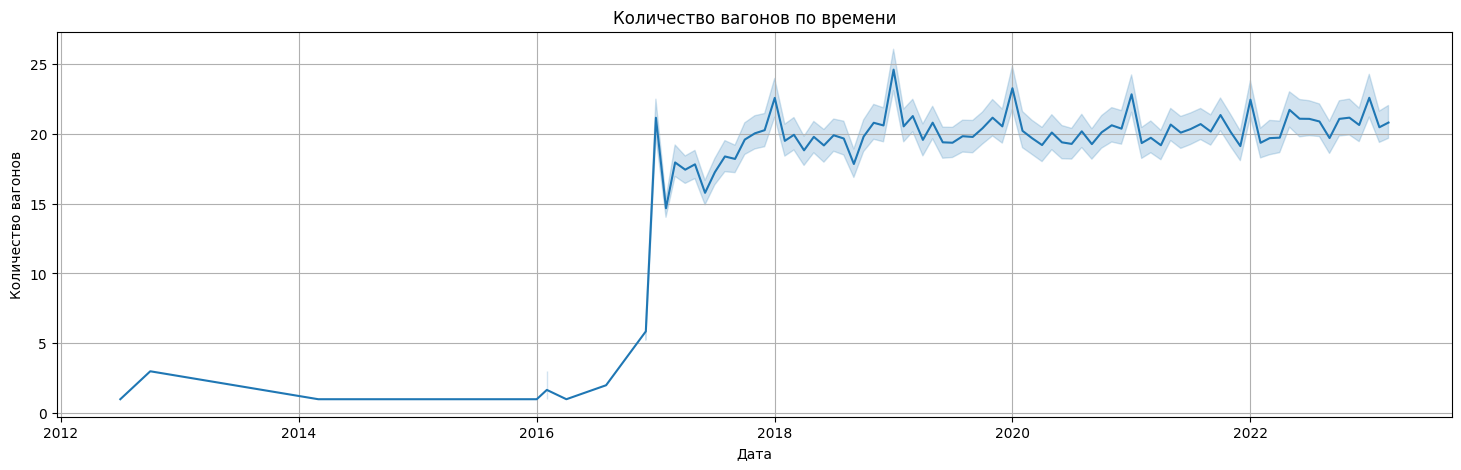

In [ ]:
plt.figure(figsize=(18, 5))
sns.lineplot(data=df, x=df.index, y="real_wagon_count")
#sns.lineplot(data=activ_store, x=activ_store.index, y="pr_sales_in_units_log")
plt.xlabel("Дата")
plt.ylabel("Количество вагонов")
plt.title("Количество вагонов по времени")
plt.grid(True)
plt.show()

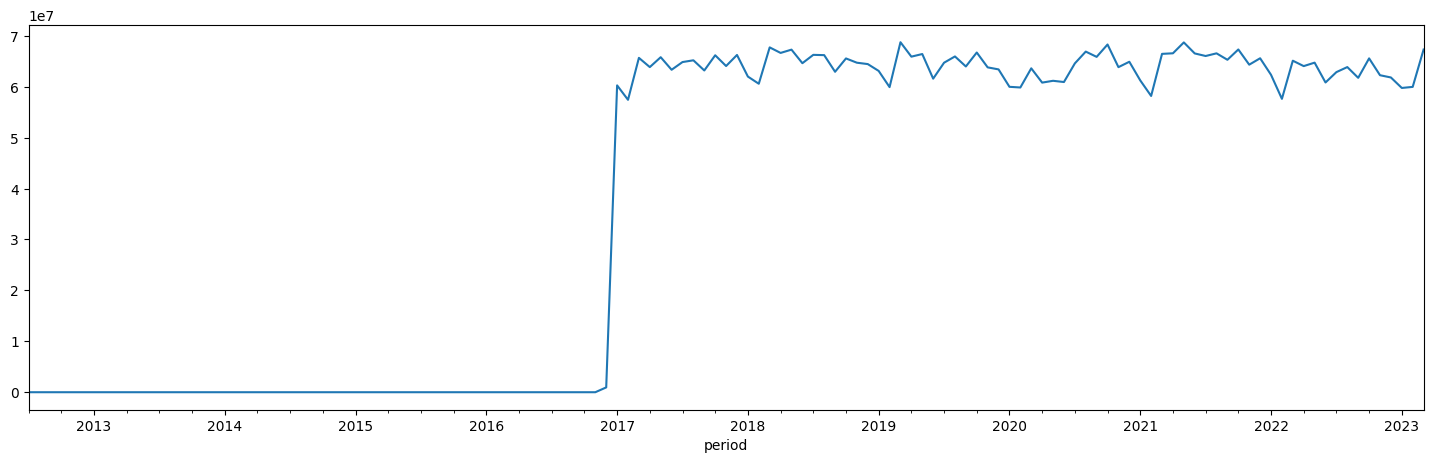

In [ ]:
plt.figure(figsize=(18, 5))
df_m = df['real_weight'].resample('1M').sum()
df_m.plot();

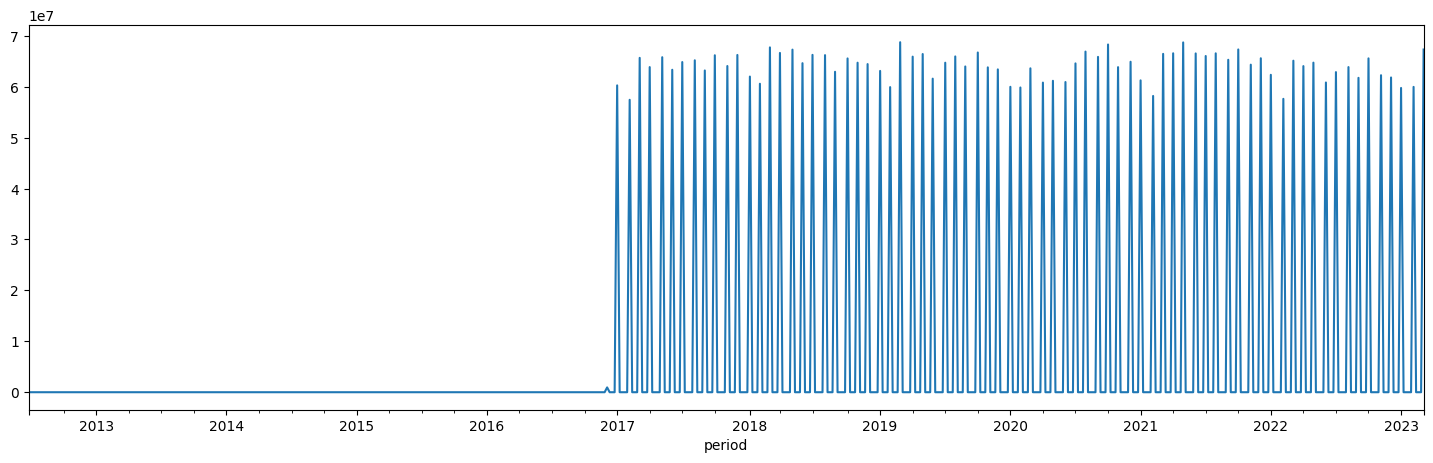

In [ ]:
plt.figure(figsize=(18, 5))
df_w = df['real_weight'].resample('1W').sum()
#data_wl = activ_store['pr_sales_in_units_log'].resample('1W').sum()
#data_w1.plot()
df_w.plot();

### **Работа с аномалиями, пропусками и дубликатами.**

#### **'real_weight'** - заменяем аномально высокие значения на медиану

In [ ]:
df[(df['real_weight'] > 500)&(df['real_wagon_count'] <= 1)].sort_values('real_weight')  #.count() #.count()

,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
period,,,,,,,,,,,,,,,,
2019-07-01,0,0,1,-1,1456,9155,35455,22473,501.000,0,NaN,31,97,23,104,10
2020-07-01,0,2,2,817,4297,8884,30966,10662,504.000,1,490.000,18,99,23,163,12
2020-08-01,0,0,2,147,4297,9352,37573,23901,504.000,1,1391.000,18,97,23,55,3
2021-05-01,0,2,2,1514,3308,2116,13568,21818,504.000,1,1472.000,20,133,25,140,30
2022-12-01,0,0,2,147,2836,9352,13635,31565,504.000,1,1391.000,34,97,23,140,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-01,0,0,2,2276,0,26290,31423,0,50351.000,1,24.000,0,124,5,73,14
2017-07-01,0,0,2,2276,0,26290,31423,0,51000.000,1,24.000,0,124,5,73,14
2019-05-01,0,0,2,588,0,32383,31423,0,64381.000,1,1795.000,0,7,33,73,14


In [ ]:
df.columns

Index(['rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'real_weight', 'real_wagon_count', 'holding_name', 'freight_group_name',
       'sender_department_name', 'sender_railway_name',
       'recipient_department_name', 'recipient_railway_name'],
      dtype='object')

In [ ]:
# Добавляем столбец wagon_load_capacity с учетом деления на 0
df['wagon_load_capacity'] = df['real_weight'] / df['real_wagon_count'].replace(0, 1)

# заменяем в real_weight отрицательные значения на 0
df.loc[(df['real_weight'] < 0), 'real_weight'] = 0

# Создаем маску для строк, где wagon_load_capacity > 125
mask = df['wagon_load_capacity'] > 125

# Фильтруем DataFrame на основе маски
df_filtered = df[mask]

# Вычисляем начальные значения для real_weight, сгруппированные по определенным столбцам
initial_values = df_filtered.groupby(['rps', 'podrod'])[['real_weight']].first()

# Вычисляем медианное значение для real_weight, сгруппированное по определенным столбцам
median_values = df_filtered.groupby(['rps', 'podrod'])[['real_weight', 'real_wagon_count']].median()

# Создаем маски для строк, где wagon_load_capacity > 6000 и где 125 < wagon_load_capacity <= 6000
mask_6000 = df['wagon_load_capacity'] > 40000
mask_125_6000 = (df['wagon_load_capacity'] > 125) & (df['wagon_load_capacity'] <= 40000)

# Обновляем строки с wagon_load_capacity > 6000, деля real_weight на 1000
df.loc[mask_6000, ['real_weight']] = df.loc[mask_6000, ['real_weight']] / 1000

# Обновляем строки с 125 < wagon_load_capacity <= 6000, заменяя real_weight на медианное значение
df.loc[mask_125_6000, ['real_weight', 'real_wagon_count']] = df.loc[mask_125_6000, ['rps', 'podrod']].apply(
 lambda row: median_values.loc[tuple(row)],
 axis=1
)

In [ ]:
df[(df['real_weight'] > 500)&(df['real_wagon_count'] <= 1)]

,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,wagon_load_capacity
period,,,,,,,,,,,,,,,,,


### **Вывод:**
- имеет смысл обрезали данные до 2016 года, так как их мало, и они могут в будущем исказить результаты прогноза
- 'real_weight' - заменили аномально высокие значения: с учетом того, что, если грузоподъемность больше 500 и меньше 40000, то берем медианное значение для такой же группы вагонов по весу груза, если больше 40000, то делим вес на 1000 (подразумевая что ошибка в данных и вес в кг)

## **3. Анализ данных, формирование признаков:**
  - Анализ данных,
  - Удаление неинформативных признаков, генерация ряда признаков, по необходимости.
  - Корреляция признаков.

### **Выделим наиболее загруженные станции:**
1 идея (обучаем 4 модели по загруженности станций)

In [ ]:
aggregated_df = pd.pivot_table(df, values=['real_weight', 'real_wagon_count'],
                                index=['sender_station_id', 'recipient_station_id'],
                                aggfunc={'real_weight': 'sum', 'real_wagon_count': 'sum'}).reset_index()
aggregated_df

,sender_station_id,recipient_station_id,real_wagon_count,real_weight
0,0,0,21,1314.000
1,0,9,128,8359.000
2,0,1186,2,130.000
3,0,1341,15,875.000
4,0,1376,18,986.000
...,...,...,...,...
205779,39123,37481,14,526.000
205780,39123,38470,38,2327.000
205781,39123,38968,29,2001.000
205782,39123,38995,18,1216.000


In [ ]:
# Создаем сводную таблицу с суммарным весом и количеством вагонов для каждой комбинации отправителя и получателя
aggregated_df = pd.pivot_table(df, values=['real_weight', 'real_wagon_count'],
                               index=['sender_station_id', 'recipient_station_id'],
                               aggfunc={'real_weight': 'sum', 'real_wagon_count': 'sum'}).reset_index()

# Сортируем по количеству вагонов 'real_wagon_count' (по убыванию)
df_wagon_count = aggregated_df.sort_values(by='real_wagon_count', ascending=False)
df_wagon_count

,sender_station_id,recipient_station_id,real_wagon_count,real_weight
62062,20384,27179,1024532,72127457.000
172857,35748,4042,748613,53627029.000
173378,35748,38905,463054,33685132.000
6492,1712,14275,451612,31593933.000
180503,36309,36269,394098,27491735.000
...,...,...,...,...
101318,29111,31756,0,52.000
101319,29111,31881,0,38.000
167526,35468,37870,0,1.000
167523,35468,37593,0,0.000


In [ ]:
# Сортируем по весу вагонов 'real_weight'
df_weight = aggregated_df.sort_values(by='real_weight', ascending=False)
df_weight

,sender_station_id,recipient_station_id,real_wagon_count,real_weight
62062,20384,27179,1024532,72127457.000
172857,35748,4042,748613,53627029.000
173378,35748,38905,463054,33685132.000
6492,1712,14275,451612,31593933.000
195885,37870,38629,388566,28966470.000
...,...,...,...,...
11564,2653,3868,5,0.000
126917,32984,2018,4,0.000
185232,36602,35601,4,0.000
2932,1444,5955,4,0.000


Агрегируем станции отправки по количеству вагонов

In [ ]:
# Создаем сводную таблицу с суммарным весом и количеством вагонов для каждой комбинации отправителя и получателя
aggregated_df = pd.pivot_table(df, values=['real_weight', 'real_wagon_count'],
                               index=['sender_station_id', 'recipient_station_id'],
                               aggfunc={'real_weight': 'sum', 'real_wagon_count': 'sum'}).reset_index()

# Сортируем по количеству вагонов 'real_wagon_count' (по убыванию)
df_wagon_count = aggregated_df.sort_values(by='real_wagon_count', ascending=False)
df_wagon_count

,sender_station_id,recipient_station_id,real_wagon_count,real_weight
62062,20384,27179,1024532,72127457.000
172857,35748,4042,748613,53627029.000
173378,35748,38905,463054,33685132.000
6492,1712,14275,451612,31593933.000
180503,36309,36269,394098,27491735.000
...,...,...,...,...
101318,29111,31756,0,52.000
101319,29111,31881,0,38.000
167526,35468,37870,0,1.000
167523,35468,37593,0,0.000


In [ ]:
# Фильтрация станций с загруженностью больше 10000 вагонов
sender_station_wagon_max = df_wagon_count[df_wagon_count['real_wagon_count'] >= 10000]
# Фильтрация станций с загруженностью меньше 10000 и больше 1000 вагонов
sender_station_wagon2 = df_wagon_count[(df_wagon_count['real_wagon_count'] <= 10000)&(df_wagon_count['real_wagon_count'] > 1000)]
# Фильтрация станций с загруженностью меньше 1000 и больше 100 вагонов
sender_station_wagon3 = df_wagon_count[(df_wagon_count['real_wagon_count'] <= 1000)&(df_wagon_count['real_wagon_count'] > 100)]
# Фильтрация станций с загруженностью меньше 100 вагонов
sender_station_wagon4 = df_wagon_count[(df_wagon_count['real_wagon_count'] <= 100)&(df_wagon_count['real_wagon_count'] > 10)]
# Фильтрация станций с загруженностью меньше 10 вагонов
sender_station_wagon1 = df_wagon_count[df_wagon_count['real_wagon_count'] <= 10]
# Фильтрация станций с загруженностью меньше 1 вагон
sender_station_wagon_min = df_wagon_count[df_wagon_count['real_wagon_count'] == 1]
# Фильтрация станций с загруженностью меньше 0 вагонов
sender_station_wagon0 = df_wagon_count[df_wagon_count['real_wagon_count'] == 0]
sender_station_wagon0.count()

# Выводим результат
sender_station_wagon_max.count()
sender_station_wagon2.count()
sender_station_wagon3.count()
sender_station_wagon4.count()
sender_station_wagon1.count()
sender_station_wagon_min.count()
sender_station_wagon0.count()

sender_station_id       40
recipient_station_id    40
real_wagon_count        40
real_weight             40
dtype: int64

In [ ]:
# Сохраняем эти станции в новом датасете
#sender_station_wagon_min.to_csv('station_wagon_min.csv', index=False)
#sender_station_wagon1.to_csv('station_wagon1.csv', index=False)
#sender_station_wagon2.to_csv('station_wagon2.csv', index=False)
#sender_station_wagon3.to_csv('station_wagon3.csv', index=False)
#sender_station_wagon_max.to_csv('station_wagon_max.csv', index=False)

In [ ]:
# Сортируем DataFrame по убыванию 'real_wagon_count'
#aggregated_df_sorted = aggregated_df.sort_values(by='real_wagon_count', ascending=False)

#plt.figure(figsize=(10, 6))
#plt.bar(aggregated_df_sorted['sender_station_id'], aggregated_df_sorted['real_wagon_count'], color='blue')
#plt.xlabel('ID станции отправителя')
#plt.ylabel('Загруженность (real_wagon_count)')
#plt.title('Загруженность станций по количеству вагонов')
#plt.xticks(rotation=45)  # Поворачиваем подписи по оси X для улучшения читаемости
#plt.show()

Обрежем данные до 2016 года

In [ ]:
df.index = pd.to_datetime(df.index)
# отбор строк с индексами больше 2016 года
df_filtered = df[df.index.year > 2016]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3556764 entries, 2017-01-01 to 2023-03-01
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   rps                        int64  
 1   podrod                     int64  
 2   filial                     int64  
 3   client_sap_id              int64  
 4   freight_id                 int64  
 5   sender_station_id          int64  
 6   recipient_station_id       int64  
 7   sender_organisation_id     int64  
 8   real_weight                float64
 9   real_wagon_count           int64  
 10  holding_name               float64
 11  freight_group_name         int64  
 12  sender_department_name     int64  
 13  sender_railway_name        int64  
 14  recipient_department_name  int64  
 15  recipient_railway_name     int64  
 16  wagon_load_capacity        float64
dtypes: float64(3), int64(14)
memory usage: 488.4 MB


In [ ]:
type_graph_list = ['rps','podrod','filial', 'sender_railway_name', 'recipient_railway_name']

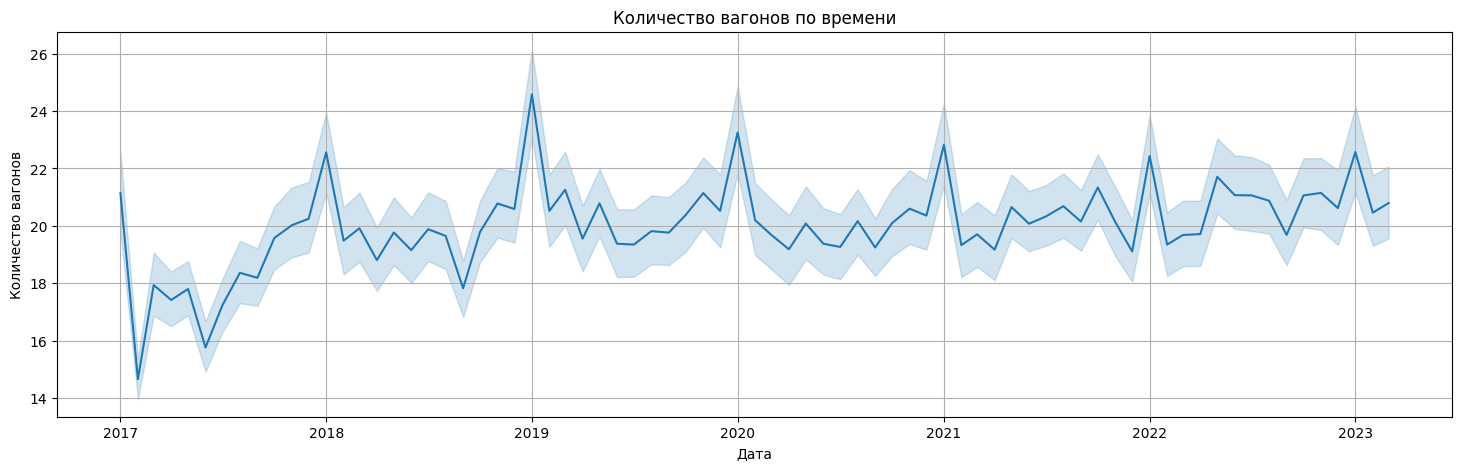

CPU times: user 56.7 s, sys: 466 ms, total: 57.1 s
Wall time: 1min 2s


In [ ]:
%%time
plt.figure(figsize=(18, 5))
sns.lineplot(data=df_filtered, x=df_filtered.index, y="real_wagon_count")
#sns.lineplot(data=activ_store, x=activ_store.index, y="pr_sales_in_units_log")
plt.xlabel("Дата")
plt.ylabel("Количество вагонов")
plt.title("Количество вагонов по времени")
plt.grid(True)
plt.show()

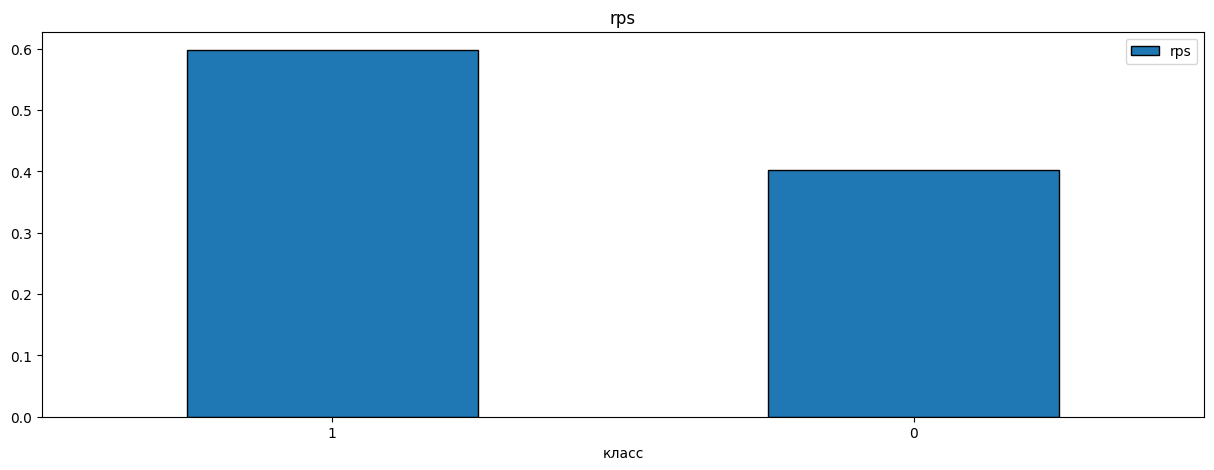

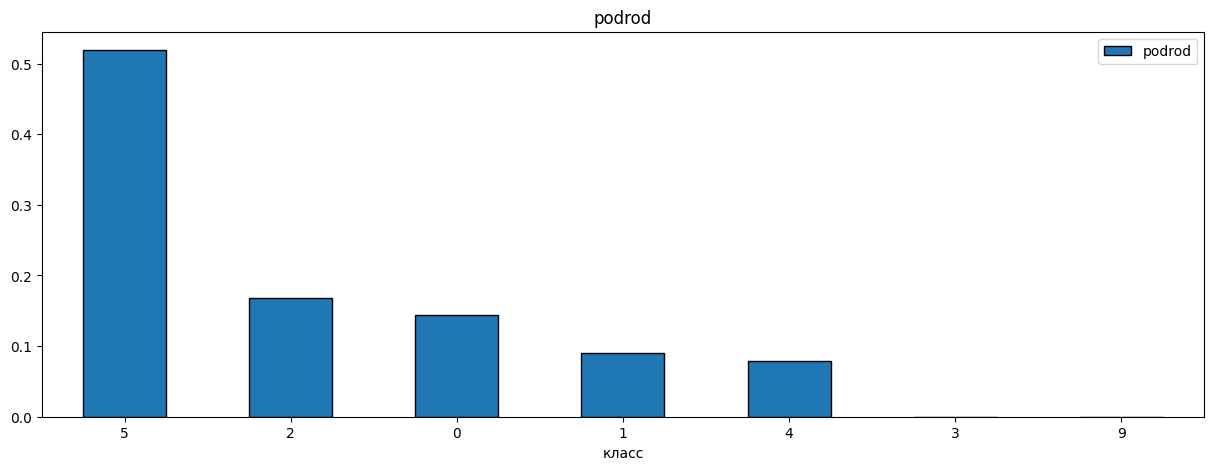

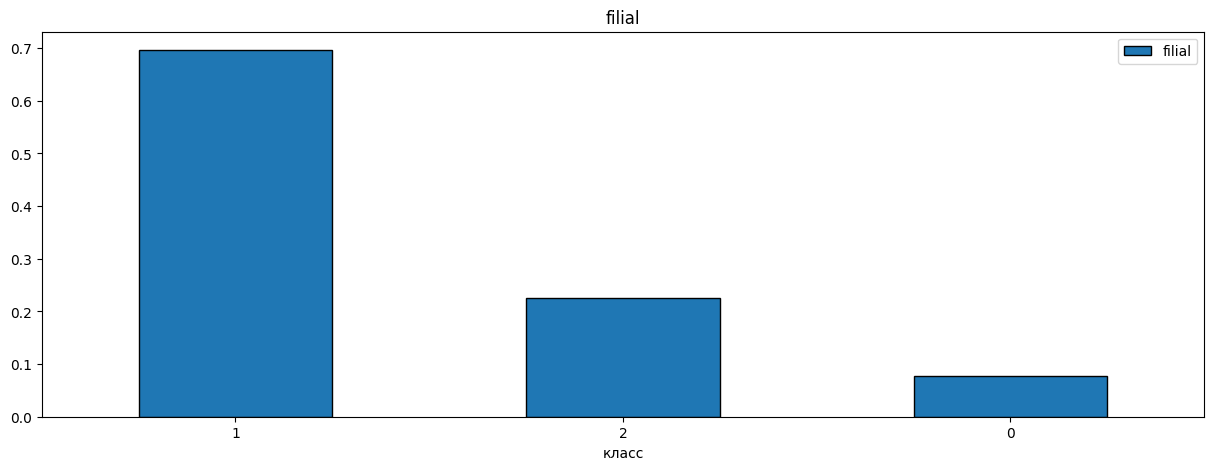

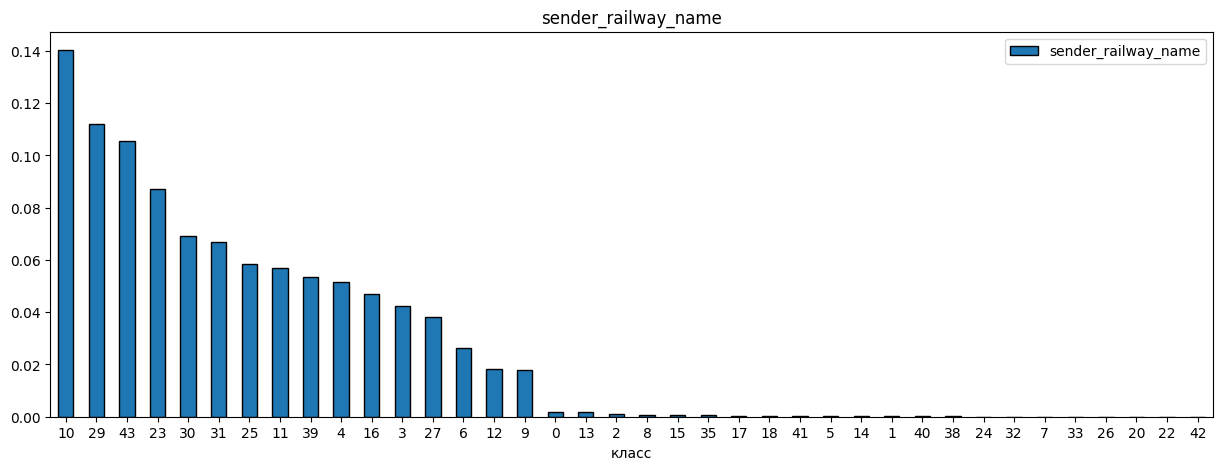

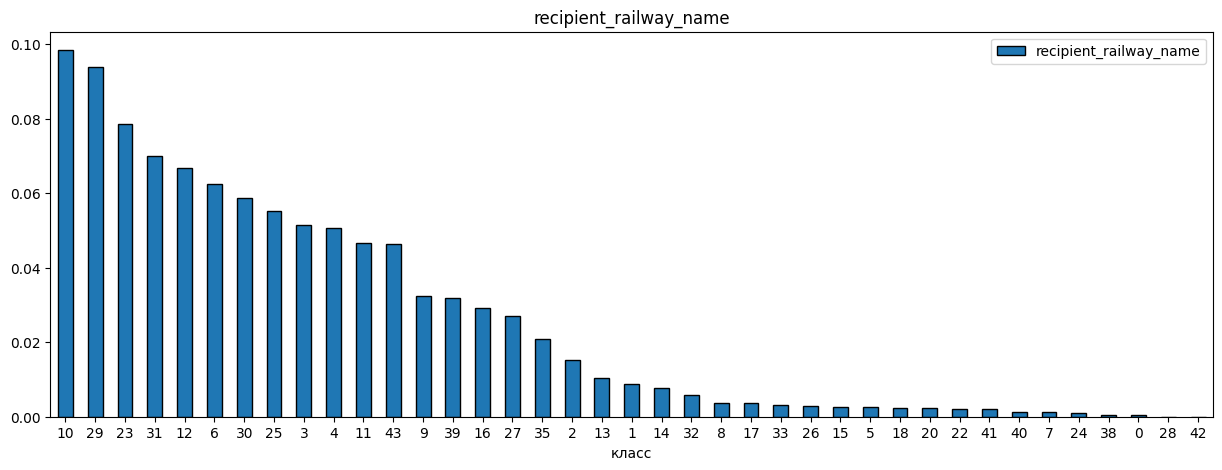

In [ ]:
for column in type_graph_list:
    class_frequency = df[column].value_counts(normalize= True).to_frame()
    #print(f'{column}',class_frequency)
    ax = class_frequency.plot(figsize=(15, 5), kind='bar', rot=0, edgecolor='black', linewidth=1)
    ax.set_xlabel('класс')
    ax.set_title(f'{column}')
    plt.show()

#### Делим общий датасет на 4 части
Удалим не информативные для нас данные до 2016 года

In [ ]:
# Сортировка DataFrame по столбцу 'real_wagon_count'
df_sorted = df_filtered.sort_values(by='real_wagon_count')
# Выбор строк, где 'real_wagon_count' меньше 10000
df_max = df_sorted[df_sorted['real_wagon_count'] >= 5000]
df_max['real_wagon_count'].count()

278

In [ ]:
# Сортировка DataFrame по столбцу 'real_wagon_count'
df_sorted = df.sort_values(by='real_wagon_count')
# Выбор строк, где 'real_wagon_count' меньше 10000
df_middle2 = df_sorted[(df_sorted['real_wagon_count'] < 5000)&(df_sorted['real_wagon_count'] >= 100)]
df_middle2['real_wagon_count'].count()

119259

In [ ]:
# Сортировка DataFrame по столбцу 'real_wagon_count'
df_sorted = df.sort_values(by='real_wagon_count')
# Выбор строк, где 'real_wagon_count' меньше 10000
df_middle3 = df_sorted[(df_sorted['real_wagon_count'] < 100)&(df_sorted['real_wagon_count'] >= 10)]
df_middle3['real_wagon_count'].count()

553766

In [ ]:
# Сортировка DataFrame по столбцу 'real_wagon_count'
df_sorted = df.sort_values(by='real_wagon_count')
# Выбор строк, где 'real_wagon_count' меньше 10000
df_min = df_sorted[df_sorted['real_wagon_count'] < 10]
df_min['real_wagon_count'].count()

2885929

In [ ]:
# Сортировка DataFrame по столбцу 'real_wagon_count'
df_sorted = df.sort_values(by='real_wagon_count')
# Выбор строк, где 'real_wagon_count' меньше 10000
df_1 = df_sorted[df_sorted['real_wagon_count'] == 1]
df_1['real_wagon_count'].count()

1319998

In [ ]:
# Сохраняем эти станции в новом датасете
df_min.to_csv('/content/df_min.csv', index=False)
df_middle3.to_csv('/content/df_middle3.csv', index=False)
df_middle2.to_csv('/content/df_middle2.csv', index=False)
df_1.to_csv('/content/df_1.csv', index=False)
df_max.to_csv('/content/df_max.csv', index=False)

In [ ]:
#plt.figure(figsize=(18, 5))
#df_m = df['real_weight'][2019-07-01:2019-08-01].resample('1D').sum()
#df_m.plot();

### Делим датасет по направлениям по загруженности
2 гипотеза: - делим на 3 части по направлениям, обучаем 3 модели

In [ ]:
df.columns

Index(['rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'real_weight', 'real_wagon_count', 'holding_name', 'freight_group_name',
       'sender_department_name', 'sender_railway_name',
       'recipient_department_name', 'recipient_railway_name',
       'wagon_load_capacity'],
      dtype='object')

In [ ]:
# группировка данных по комбинации sender_station_id и recipient_station_id
grouped_data = df_filtered.groupby(['sender_station_id', 'recipient_station_id']).size().reset_index(name='count')
grouped_data


grouped_data.sort_values(by=('count'), ascending=False)

# словарь для хранения результатов
count_occurrences = {}

# от 1 до 10 и подсчитывать количество раз для каждого значения 'count'
for i in range(1, 11):
    count_occurrences[i] = (grouped_data['count'] == i).sum()

# результаты
for count_value, occurrences in count_occurrences.items():
    print(f"Количество раз, когда маршрут использовался {count_value} раз: {occurrences}")

Количество раз, когда маршрут использовался 1 раз: 54709
Количество раз, когда маршрут использовался 2 раз: 28129
Количество раз, когда маршрут использовался 3 раз: 16796
Количество раз, когда маршрут использовался 4 раз: 12070
Количество раз, когда маршрут использовался 5 раз: 8830
Количество раз, когда маршрут использовался 6 раз: 7030
Количество раз, когда маршрут использовался 7 раз: 5660
Количество раз, когда маршрут использовался 8 раз: 4918
Количество раз, когда маршрут использовался 9 раз: 4064
Количество раз, когда маршрут использовался 10 раз: 3644


In [ ]:
#import sweetviz as sv
#report = sv.analyze([df, "Wagon"])

In [ ]:
#report.show_html('common analysis.html')

## **4. Построение и обучение модели:**
- Подготовка данных для обучения модели:
  - Кодирование и масштабирование признаков - стандартизация данных, по необходимости.
  - Разделение общего датасета на выборки для обучения и проверки модели.
- Обучение моделей:
    - Классические модели:
       - Предварительная проверка моделей.
       - Линейная регрессия.
       - CatBoostRegressor,
    - Orbit.

### Подготовка датасета для обучения модели
- Кодирование и масштабирование признаков - стандартизация данных, по необходимости.
- Разделение общего датасета на выборки для обучения и проверки модели.

In [ ]:
df_max.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 278 entries, 2019-04-01 to 2018-12-01
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   rps                        278 non-null    int64  
 1   podrod                     278 non-null    int64  
 2   filial                     278 non-null    int64  
 3   client_sap_id              278 non-null    int64  
 4   freight_id                 278 non-null    int64  
 5   sender_station_id          278 non-null    int64  
 6   recipient_station_id       278 non-null    int64  
 7   sender_organisation_id     278 non-null    int64  
 8   real_weight                278 non-null    float64
 9   real_wagon_count           278 non-null    int64  
 10  holding_name               261 non-null    float64
 11  freight_group_name         278 non-null    int64  
 12  sender_department_name     278 non-null    int64  
 13  sender_railway_name        278 

In [ ]:
def convert_cat(data):
      columns_to_convert = ['rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
                       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
                       'holding_name', 'freight_group_name', 'sender_department_name',
                       'sender_railway_name', 'recipient_department_name', 'recipient_railway_name']

      data[columns_to_convert] = data[columns_to_convert].astype('category')
      return data

In [ ]:
df_max = convert_cat (df_max)
df_middle2 = convert_cat (df_middle2)
df_middle3 = convert_cat (df_middle3)
df_min = convert_cat (df_min)

In [ ]:
def form_numeric_cat_data(data):
    num_data = data.select_dtypes(include=[np.number])
    cat_data = data[data.select_dtypes(include='category').columns]
    return num_data, cat_data

In [ ]:
num_data, cat_data = form_numeric_cat_data(df_max)
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 278 entries, 2019-04-01 to 2018-12-01
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   rps                        278 non-null    category
 1   podrod                     278 non-null    category
 2   filial                     278 non-null    category
 3   client_sap_id              278 non-null    category
 4   freight_id                 278 non-null    category
 5   sender_station_id          278 non-null    category
 6   recipient_station_id       278 non-null    category
 7   sender_organisation_id     278 non-null    category
 8   holding_name               261 non-null    category
 9   freight_group_name         278 non-null    category
 10  sender_department_name     278 non-null    category
 11  sender_railway_name        278 non-null    category
 12  recipient_department_name  278 non-null    category
 13  recipient_railwa

In [ ]:
num_data

,real_weight,real_wagon_count,wagon_load_capacity
period,,,
2019-04-01,328115.000,5003,65.584
2019-07-01,349258.000,5019,69.587
2023-02-01,347619.000,5032,69.082
2018-01-01,355600.000,5044,70.500
2022-03-01,374427.000,5044,74.232
...,...,...,...
2021-12-01,774488.000,11169,69.343
2018-11-01,777420.000,11207,69.369
2019-01-01,800691.000,11534,69.420


In [ ]:
#разобьем данные на выборки
def split_data (data, target_name):
    train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
    train = train.dropna()

    features_train = train.drop(target_name, axis=1)
    target_train = train[target_name]
    features_test = test.drop(target_name, axis=1)
    target_test = test[target_name]

    return features_train, target_train, features_test, target_test

In [ ]:
features_train1, target_train1, features_test1, target_test1 = split_data (df_max, 'real_weight')
features_train2, target_train2, features_test2, target_test2 = split_data (df_middle2, 'real_weight')
features_train4, target_train4, features_test4, target_test4 = split_data (df_min, 'real_weight')
features_train3, target_train3, features_test3, target_test3 = split_data (df_middle3, 'real_weight')

In [ ]:
features_train11, target_train11, features_test11, target_test11 = split_data (df_max, 'real_wagon_count')
features_train22, target_train22, features_test22, target_test22 = split_data (df_middle2, 'real_wagon_count')
features_train44, target_train44, features_test44, target_test44 = split_data (df_min, 'real_wagon_count')
features_train33, target_train33, features_test33, target_test33 = split_data (df_middle3, 'real_wagon_count')

In [ ]:
df_middle3.shape

(553766, 17)

In [ ]:
df_middle2.shape

(119259, 17)

### Обучение модели
- Классические модели:
    - Предварительная проверка моделей.
    - Линейная регрессия.
    - CatBoostRegressor,
- ARIMA
- Orbit(по возможности).

In [ ]:
# параметры для подбора
parameters_cbr = [{'learning_rate':[0.1, 0.5, 0.8],
               'depth':[6,8,10],
               'iterations':[30, 50, 100],
               'verbose':[False]}]

In [ ]:
# Определим число разбиений (n_splits) автоматически
n_splits = TimeSeriesSplit().get_n_splits([df])
# Создание объекта TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

In [ ]:
def train_model(features_train, target_train, name_model, param_dist):
    pipeline = Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
                    ('catboost', name_model(random_state=RANDOM_STATE))
    ])

    # определяем RandomizedSearchCV
    random_search = RandomizedSearchCV(
                    pipeline, param_distributions=param_dist, n_iter=10,
                    scoring='neg_mean_squared_error', cv=tscv, random_state=RANDOM_STATE
    )
    random_search.fit(features_train, target_train)

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    rmse = random_search.best_score_* -1
    return best_model, best_params, rmse

def results (best_model, best_params, rmse, name_model):
    print('\033[1m'+ f'Модель {name_model}'+'\033[0m')
    print('\033[1m'+'RMSE:'+'\033[0m', rmse)
    print('='*75)
    print(f"Лучшие параметры для {name_model}:\n", best_params)
    print('='*75)
#print("Лучшие параметры:", best_params)


# параметры для подбора
param_dist = {
    'catboost__iterations': [30, 50, 100],
    'catboost__learning_rate': [0.01, 0.05, 0.1],
    'catboost__depth':[6,8,10],
    'catboost__verbose':[False],
}

#### Обучим модель на целевом признаке `real_weight`

In [ ]:
%%time
tqdm.pandas()
model1, params1, rmse1 = train_model(features_train1, target_train1, CatBoostRegressor, param_dist)
results(model1, params1, rmse1, CatBoostRegressor)

Модель <class 'catboost.core.CatBoostRegressor'>
RMSE: 2654748770.4678755
Лучшие параметры для <class 'catboost.core.CatBoostRegressor'>:
 {'catboost__verbose': False, 'catboost__learning_rate': 0.1, 'catboost__iterations': 100, 'catboost__depth': 6}
CPU times: user 6.59 s, sys: 445 ms, total: 7.04 s
Wall time: 5.61 s


In [ ]:
%%time
tqdm.pandas()
model_middle2, params_middle2, rmse_middle2 = train_model(features_train2, target_train2, CatBoostRegressor, param_dist)
results(model_middle2, params_middle2, rmse_middle2, CatBoostRegressor)

Модель <class 'catboost.core.CatBoostRegressor'>
RMSE: 45720921.18933623
Лучшие параметры для <class 'catboost.core.CatBoostRegressor'>:
 {'catboost__verbose': False, 'catboost__learning_rate': 0.1, 'catboost__iterations': 100, 'catboost__depth': 8}
CPU times: user 2min 11s, sys: 5.71 s, total: 2min 17s
Wall time: 2min 20s


In [ ]:
%%time
tqdm.pandas()
model_middle3, params_middle3, rmse_middle3 = train_model(features_train3, target_train3, CatBoostRegressor, param_dist)
results(model_middle3, params_middle3, rmse_middle3, CatBoostRegressor)

Модель <class 'catboost.core.CatBoostRegressor'>
RMSE: 211431.96876375185
Лучшие параметры для <class 'catboost.core.CatBoostRegressor'>:
 {'catboost__verbose': False, 'catboost__learning_rate': 0.1, 'catboost__iterations': 100, 'catboost__depth': 8}
CPU times: user 5min 10s, sys: 7.3 s, total: 5min 17s
Wall time: 3min 43s


In [ ]:
%%time
tqdm.pandas()
model_middle4, params_middle4, rmse_middle4 = train_model(features_train4, target_train4, CatBoostRegressor, param_dist)
results(model_middle4, params_middle4, rmse_middle4, CatBoostRegressor)

Модель <class 'catboost.core.CatBoostRegressor'>
RMSE: 2316.1550748731192
Лучшие параметры для <class 'catboost.core.CatBoostRegressor'>:
 {'catboost__verbose': False, 'catboost__learning_rate': 0.1, 'catboost__iterations': 100, 'catboost__depth': 8}
CPU times: user 19min 24s, sys: 17.1 s, total: 19min 41s
Wall time: 14min 34s


#### Обучим модель на целевом признаке `real_wagon_count`

In [ ]:
%%time
tqdm.pandas()
model11, params11, rmse11 = train_model(features_train11, target_train11, CatBoostRegressor, param_dist)
results(model11, params11, rmse11, CatBoostRegressor)

Модель <class 'catboost.core.CatBoostRegressor'>
RMSE: 598184.5349674659
Лучшие параметры для <class 'catboost.core.CatBoostRegressor'>:
 {'catboost__verbose': False, 'catboost__learning_rate': 0.1, 'catboost__iterations': 100, 'catboost__depth': 6}
CPU times: user 8.02 s, sys: 510 ms, total: 8.54 s
Wall time: 6.79 s


In [ ]:
%%time
tqdm.pandas()
model_middle22, params_middle22, rmse_middle22 = train_model(features_train22, target_train22, CatBoostRegressor, param_dist)
results(model_middle22, params_middle22, rmse_middle22, CatBoostRegressor)

Модель <class 'catboost.core.CatBoostRegressor'>
RMSE: 9365.129548015799
Лучшие параметры для <class 'catboost.core.CatBoostRegressor'>:
 {'catboost__verbose': False, 'catboost__learning_rate': 0.1, 'catboost__iterations': 100, 'catboost__depth': 6}
CPU times: user 2min 13s, sys: 3.9 s, total: 2min 17s
Wall time: 1min 30s


In [ ]:
%%time
tqdm.pandas()
model_middle33, params_middle33, rmse_middle33 = train_model(features_train33, target_train33, CatBoostRegressor, param_dist)
results(model_middle33, params_middle33, rmse_middle33, CatBoostRegressor)

Модель <class 'catboost.core.CatBoostRegressor'>
RMSE: 45.89349106165987
Лучшие параметры для <class 'catboost.core.CatBoostRegressor'>:
 {'catboost__verbose': False, 'catboost__learning_rate': 0.1, 'catboost__iterations': 100, 'catboost__depth': 6}
CPU times: user 5min 15s, sys: 7.26 s, total: 5min 23s
Wall time: 4min 25s


In [ ]:
%%time
tqdm.pandas()
model_middle4, params_middle4, rmse_middle4 = train_model(features_train4, target_train4, CatBoostRegressor, param_dist)
results(model_middle4, params_middle4, rmse_middle4, CatBoostRegressor)

Модель <class 'catboost.core.CatBoostRegressor'>
RMSE: 2316.1550748731192
Лучшие параметры для <class 'catboost.core.CatBoostRegressor'>:
 {'catboost__verbose': False, 'catboost__learning_rate': 0.1, 'catboost__iterations': 100, 'catboost__depth': 8}
CPU times: user 19min 2s, sys: 16 s, total: 19min 18s
Wall time: 13min 23s


### **ARIMA**

In [ ]:
n_splits = TimeSeriesSplit(n_splits=3).split(df_max)
for train_index, test_index in n_splits:
    X_train, X_test = df_max.iloc[train_index], df_max.iloc[test_index]
    y_train, y_test = X_train['real_wagon_count'], X_test['real_wagon_count']

# Fit auto_arima model
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1883.386, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2045.316, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1974.559, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1888.842, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2043.316, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1881.078, Time=0.54 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1961.651, Time=0.29 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1855.321, Time=0.53 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1890.416, Time=0.72 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=1856.031, Time=0.76 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1846.555, Time=0.89 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1877.289, Time=0.94 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=1848.543, Time=1.31 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=1839.297, Time=1.18 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept

In [ ]:
# Make predictions
y_pred = model.predict(n_periods=len(y_test))
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"RMSE: {rmse}")

RMSE: 1350.4972332889893


In [ ]:
n_splits = TimeSeriesSplit(n_splits=3).split(df_middle2)
for train_index, test_index in n_splits:
    X_train, X_test = df_middle2.iloc[train_index], df_middle2.iloc[test_index]
    y_train, y_test = X_train['real_wagon_count'], X_test['real_wagon_count']

# Fit auto_arima model
model2 = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# Make predictions
y_pred2 = model2.predict(n_periods=len(y_test))
rmse = mean_squared_error(y_test, y_pred2, squared=False)

print(f"RMSE: {rmse}")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-252867.481, Time=10.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-252870.389, Time=18.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-252869.478, Time=16.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-252869.483, Time=9.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-252560.847, Time=5.46 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 63.254 seconds
RMSE: 856.9116456754183


In [ ]:
# Split data into train/test
n_splits = TimeSeriesSplit(n_splits=3).split(df_middle3)
for train_index, test_index in n_splits:
    X_train, X_test = df_middle3.iloc[train_index], df_middle3.iloc[test_index]
    y_train, y_test = X_train['real_wagon_count'], X_test['real_wagon_count']

# Fit auto_arima model
model3 = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# Make predictions
y_pred3 = model3.predict(n_periods=len(y_test))
rmse3 = mean_squared_error(y_test, y_pred3, squared=False)

print(f"RMSE: {rmse3}")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2810406.470, Time=107.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2810410.468, Time=96.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2810408.470, Time=79.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2810408.470, Time=80.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2810384.467, Time=26.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 418.920 seconds
RMSE: 22.673262711336818


In [ ]:
n_splits = TimeSeriesSplit(n_splits=3).split(df_min)
for train_index, test_index in n_splits:
    X_train, X_test = df_min.iloc[train_index], df_min.iloc[test_index]
    y_train, y_test = X_train['real_wagon_count'], X_test['real_wagon_count']

# Fit auto_arima model
model4 = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)


In [ ]:
# Make predictions
y_pred4 = model4.predict(n_periods=len(y_test))
rmse4 = mean_squared_error(y_test, y_pred4, squared=False)

print(f"RMSE: {rmse4}")

### **2 Гипотеза - обучение по 3м датасетам (по загруженности направлений)**
Разбиение датасета по направлением, обучение по временным периодам, как в 3 гипотезе.
https://drive.google.com/file/d/1JkY6kw43zk8jmUJL8nFiGFeG-oY1yeeq/view?usp=sharing

- Обучение на **CatBoostRegressor**
- **Резльтат метрики: 0.65**

### **3 Гипотеза - обучение модели по временным периодам (берем весь датасет)**

https://colab.research.google.com/drive/12QCZYjEz8tlGUe7y5sTDlAEIn3f-DbIF?usp=sharing#scrollTo=9DyNcuWXfSxk

- Обучение на **CatBoostRegressor**
- **Результат метрики: 0.664**


### **Выводы:**
- проверили 3 гипотезы:
  - 1 - разбиение на 4 датасета по загруженности станций отправления. применяли ARIMA и CatBoostRegressor. Арима давала лучший результат изначально, но на 4 датасете (2 млн), код упал. Надо дорабатывать.
  - 2 - обучение по 3м датасетам (по загруженности направлений), обучение по временным промежуткам:
     - Обучение на CatBoostRegressor (без перебора поараметров)
     - Резльтат метрики: 0.65
     - результат можно улучшить точно

  - 3 Гипотеза - обучение модели по временным периодам (берем весь датасет).
   - Пока эта модель дала лучший результат.
   - Обучение на **CatBoostRegressor**
   - **Результат метрики: 0.664**
- есть предположение, что при использовании подхода 2 и обучение на 3х датасетах по направлениям АRIMA даст лучший результат
- также можно точно улучшить метрику по 2 гипотезе, если подобрать параметры.

##  **5. Выбор лучшей модели. Тестирование.**
лучшая модель
https://colab.research.google.com/drive/12QCZYjEz8tlGUe7y5sTDlAEIn3f-DbIF?usp=sharing#scrollTo=9DyNcuWXfSxk

### **Подготовка кода для предсказания и теcтирования моделей**

#### для Аримы

In [ ]:
#для Аримы
def predict(features_test, target_test):
    y_pred = model1.predict(n_periods=len(features_test1))
    rmse = mean_squared_error(target_test1, y_pred, squared=False)

    print(f"RMSE: {rmse}")

#### для Катбуста

In [ ]:
# Создаем датасет для предсказаний на 7 месяцев вперед
#last_date = features_test22.index[-1]  # Последняя дата в features_test
#future_dates = pd.date_range(start=last_date, periods=7, freq='M')  # Создаем 7 будущих месяцев
#future_features = pd.DataFrame(index=future_dates, columns=features_test1.columns)  # Создаем датасет для будущих признаков

# Предсказываем значения для будущих признаков
#future_pred = model_middle22.predict(future_features)

# Выводим предсказания
#print("Предсказания на 7 месяцев вперед:")
#print(future_pred)

In [ ]:
def test_model(features_test, target_test, model, name_model):
    pred = model1.predict(features_test)
    rmse = mean_squared_error(target_test, pred, squared=False)
    #data = data.reset_index()

    # Добавление столбца к датасету
    features_test['forecast_weight'] = pred
    print(f"RMSE {name_model}: {rmse}")
    return pred, rmse #, features_test, forecast1

# Применение функции к вашему датасету df
pred1, rmse1 = test_model(features_test1, target_test1, model1, 'CatBoostRegressor')

In [ ]:
def test_model1(features_test, target_test, model, name_model):
    pred = model.predict(features_test)
    rmse = mean_squared_error(target_test, pred, squared=False)

    # prediction на 7 месяцев вперед
    future_features = features_test.copy()
    for _ in range(7):
        # Assuming you have a function or method to predict a single step forward
        future_pred = model.predict(future_features.iloc[-1:])

        # Переименовываем признак перед добавлением в future_features
        future_features = future_features.append({'forecast_wagon_count': future_pred[0]}, ignore_index=True)
        future_features.columns = features_test.columns

    print(f"RMSE {name_model}: {rmse}")
    return future_pred, rmse, future_features

In [ ]:
#pred22, rmse22, future_features22 = test_model1(features_test22, target_test22, model_middle22, 'CatBoostRegressor')

In [ ]:
#pred3, rmse3 = test_model(features_test3, target_test3, model_middle3, 'CatBoostRegressor')
# Применение функции к вашему датасету df
#pred1, rmse1 = test_model(features_test1, target_test1, model1, 'CatBoostRegressor')
#pred4, rmse4 = test_model(features_test4, target_test4, model_middle4, 'CatBoostRegressor')
#pred22, rmse22, future_features22 = test_model1(features_test22, target_test22, model_middle22, 'CatBoostRegressor')

RMSE CatBoostRegressor: 363525.9691717376


### Подготовака итогового датасета для проверки
 - Соединим данные в один датасет

In [ ]:
def forecast_form(features_test, pred):
    forecast = features_test.copy()
    forecast['forecast_weight'] = pred
    return forecast

#forecast1 = forecast_form(features_test1, pred11)
#forecast2 = forecast_form(features_test2, pred22)
#forecast3 = forecast_form(features_test3, pred33)
#forecast4 = forecast_form(features_test4, pred4)

In [ ]:
#forecast4.columns

Index(['rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'real_wagon_count', 'holding_name', 'freight_group_name',
       'sender_department_name', 'sender_railway_name',
       'recipient_department_name', 'recipient_railway_name',
       'wagon_load_capacity', 'forecast_weight'],
      dtype='object')

In [ ]:
forecast_example.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_weight', 'forecast_wagon_count'],
      dtype='object')

In [ ]:
# Объединение данных по индексу "period"
#forecast = pd.concat([forecast1, forecast2, forecast3, forecast4], axis=0)
#forecast = forecast.reset_index(drop=False).sort_values(by='period').reset_index(drop=True)
#Выведем дату из индекса
#forecast = forecast.reset_index(drop=False)

# Оставляем только указанные колонки
#selected_columns = ['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
#                    'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
#                    'forecast_weight']
#
#forecast = forecast[selected_columns]
#forecast
#forecast.to_csv('/content/forecast.csv', index=False)

## **6. Выводы**
- **Гипотезы:**
 - на старте было 3 гипотезы:
  - 1 - разделение датасета по загруженности станций отправления (разделили на 4 части: максимально загруженную (более 10т вагонов), средне-загруженную, малозагруженную и минимально загруженные (до 10 шт вагонов). Обучить 4 модели по этим датасетам, затем делать предсказание с помощью моделей соответствующих групп.
  - 2 - разделение по направлениям поездов с точки зрения популярноти (малозакруженное, средне-загруженное, сильно загруженное). Обучить модели по этим датасетам, затем делать предсказание с помощью моделей соответствующих групп.
  - 3 - провести обучение по всему датасету по периодам.
- **Результаты:**
По итогу проверки гипотез получили следующее:
 - **Лучшая модель 3 гипотезы** - обучении данных на временных периодах, при помощи **CatBoost**:
  > при загрузке данных на платформу - дал результат по оценке качества в	**0.667**
 - на проверке находится комбинация 2 и 3 гипотез - разбиение датасета по частоте направлений - 3 датасета, обучаем каждый временным периодам согласно подходу в 3 гипотезы. Пока прогнали без гридсеча - 0.65.
 - Хорошие результаты дал подход на разбиение на 4 части датасета по загруженности пунктов отправления: хорошо показала себя модель **ARIMA**, но к сожелению, не успели досчитать 4 датасет в 2 миллиона, нехватило ресурсов.

- **Что можно улучшить:**
 - Доделать обучение на Ариме согласно 1 гипотезе.
 - Проверить как ведет себя Арима при подходе разбиения на направления.
 - У нас была идея предсказывать тоннаж и по нему высчитывать количество вагонов, но данных не хватило открытых по типам и подтипам вагонов, можно а в зашифрованные данные не было времени углубляться в исследования.
 - можно поработать с аномалиями и чисткой данных.
 - Доработать совмещение 2 и 3 гипотез, без подбора параметров уже хороший результат.
- **Чего не хватает для реализации продукта и дальнейшего масштабирования?**
 - доступа к данным типов вагонов, незашифрованных, это бы ускорило результаты анализа и группировки
 - формул расчета грузоподъемности по типам вагонов, чтобы проверить наш подход предсказаний по весу грузов.  По нему высчитывать количество вагонов.
 - ресурсов;
  -  времени, что-то мы могли бы улучшить сами, было бы чуть больше времени,
  - технических ресурсов - Арима на 2млн вылетает, но было бы время можно было бы подумать что сделать.

# Образец результата

прогноз на апрель - август 2023, сделанный на данных до марта включительно

In [ ]:
# Факт на задание
fact = pd.read_csv("C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\fact_train_test.csv", sep=";", decimal=",", encoding="windows-1251")
fact["period"] = fact["period"].astype("datetime64[ns]")
# fact - уже обрезанная выборка

# Пример прогноза - наивный, копия последнего факта
result = []
last_known_fact_month = fact["period"].max()
test_periods = pd.date_range(start=last_known_fact_month, periods=6, freq='MS', inclusive='right')
for period in test_periods:
    print(period)
    month_forecast = fact[fact["period"] == last_known_fact_month].reset_index(drop=True)
    month_forecast["period"] = period
    result.append(month_forecast)
result = pd.concat(result).reset_index(drop=True)
result.rename(columns={"real_wagon_count": "forecast_wagon_count", "real_weight": "forecast_weight"}, inplace=True)
result.to_csv("C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\forecast_example.csv", index=False, sep=";", decimal=",", encoding="windows-1251")


# Оценка результата

In [ ]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    # = Пути к справочникам - откорректировать если в реальной системе будут лежать по другому адресу =
    client_mapping_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\client_mapping.csv"
    freight_mapping_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\freight_mapping.csv"
    station_mapping_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\station_mapping.csv"

    # Клиент - холдинг
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")

    # Груз
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")

    # Станции
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df


def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"
    if public:
        metric_weight = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
    else:
        metric_weight = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    fact = add_master_data_mappings(fact)
    forecast = add_master_data_mappings(forecast)

    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    score = (
        summary["Forecast Accuracy"].sort_index(ascending=True) * metric_weight
    ).sum()

    return score


def calc_score_public(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=True)


def calc_score_private(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=False)



In [ ]:
#add_master_data_mappings(fact)

In [ ]:
# = Примеры файлов для проверки =
validation_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\fact_validation.csv"
forecast_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\forecast_example.csv"

# Валидационный датасет
fact = pd.read_csv(validation_file, sep=";", decimal=",", encoding="windows-1251")
# print("Валидационный датасет:", fact.shape)
# Прогноз
forecast = pd.read_csv(forecast_file, sep=";", decimal=",", encoding="windows-1251")
# print("Прогноз:", forecast.shape)

# Скорим
score_public = calc_score_public(fact, forecast)
score_private = calc_score_private(fact, forecast)
print(f"Public score: {score_public}")
print(f"Private score: {score_private}")
